In [1]:
import wget
import healpy as hp
import numpy as np
import pylab as pl 
from pathlib import Path
import scipy
from scipy.optimize import curve_fit

from astropy import units as u, constants as const



def b(nu):
    """
    estimate dI/dT_CMB as defined in eq. 8 of Planck 2013 IX
    """
    nu0 = 56.8 * u.GHz
    x = nu / nu0
    Tcmb = 2.7255 * u.K
    bb = (
        2
        * const.h
        * nu ** 3
        / const.c ** 2
        / Tcmb
        * (x * np.exp(x) / (np.exp(x) - 1) ** 2)
    )
    return bb.to(u.W / u.m ** 2 / u.K / u.Hz)


def b_rj(nu):
    """
    estimate dI/dT_RJ as defined in eq. 30 of Planck 2013 IX
    """
    bb = 2 * const.k_B * nu ** 2 / const.c ** 2
    return bb.to(u.W / u.m ** 2 / u.K / u.Hz)

def brightness2Tcmb(nu, bandpass=None):
    """
    Convert from Jy/srad  to K_CMB
    """
    try:
        nu.unit
    except AttributeError:
        nu *= u.GHz

    if bandpass is None:
        integrand = b(nu)
        conversion_factor = 1 / integrand
    else:
        bandpass /= u.GHz
        integrand = b(nu) * bandpass
        conversion_factor = 1 / np.trapz(integrand, x=(nu))
    return conversion_factor


def brightness2Trj(nu, bandpass=None):
    """
    Convert from Jy/srad to K_RJ
    """
    try:
        nu.unit
    except AttributeError:
        nu *= u.GHz

    if bandpass is None:
        integrand = b_rj(nu)
        conversion_factor = 1 / integrand
    else:
        bandpass /= u.GHz
        integrand = b_rj(nu) * bandpass
        conversion_factor = 1 / np.trapz(integrand, x=(nu))
    return conversion_factor


def Krj2Kcmb(nu, Trj=1.0, bandpass=None):
    """
    Convert antenna temperature ( Rayleigh-Jeans) into the physical one
    """
    return Trj / Kcmb2Krj(
        nu=nu, Tcmb=1, bandpass=bandpass
    )  # (x ** 2 * np.exp(x) / (np.exp(x) - 1) ** 2)


def Kcmb2Krj(nu, Tcmb=1.0, bandpass=None):
    return (
        brightness2Trj(nu=nu, bandpass=bandpass)
        / brightness2Tcmb(nu=nu, bandpass=bandpass)
        * Tcmb
    )



In [2]:
from scipy.odr import Model, Data, ODR
from scipy.stats import linregress

def rotate_map(mapin, coord_in , coord_out ) : 
    alm = hp.map2alm (mapin )
    R=  hp.Rotator(coord=[coord_in, coord_out ])
    alm =  R.rotate_alm (alm )
    map_out = hp.alm2map (alm , nside= hp.get_nside(mapin ))
    return map_out


def get_betas(xdat, xnoise, ydat, ynoise, v1, v2):
    """perform linear regression between two data set and get spectral index """

    mydata = Data(xdat, ydat, wd=xnoise**-2, we=ynoise**-2)
    myodr = ODR(mydata, Model(sform), beta0=[0.05, 0.5])
    myoutput = myodr.run()
    fitted_gradient = myoutput.beta[0]
    error_gradient = myoutput.sd_beta[0]

    ef = np.log(v2/v1)
    beta = np.log(fitted_gradient) / ef
    beta_error = error_gradient / (fitted_gradient * ef)

    #if beta > -2.1 or beta < -3.5:
    #    plt.plot(xdat, ydat, '.')
    #    plt.plot(xdat, fitted_gradient*xdat +  myoutput.beta[1], 'r-')
    #    plt.show()

    #    print("breaking here")
    
    return beta, beta_error, myoutput 
    
def sform(param, xxx):
    '''linear reggression'''
    return xxx * param[0] + param[1]
def fitting_beta_curvature(X, beta, cs):
   return beta*X +cs*X*X 

def sfunc(xxx, bval, cval):
    '''linear reggression'''
    return xxx * bval + cval

def remove_off(map, hasmap , nside_superpix=8  ):
    nside_superpix=8
    nan1 =np.ma.masked_invalid (map).mask 
    npix = map.size 
    pixs = np.arange(npix)
    try : 
        ang = hp.pix2ang(ipix= pixs[nan1][0] , nside= hp.get_nside(map)) 
        pix1 = hp.ang2pix(theta=ang[0] , phi = ang[1] , nside= nside_superpix)
    

        if pixs[nan1] [0]==0 :
            print("Southern Survey ") 
            super_pixs=  np.arange(pix1, hp.nside2npix(nside_superpix)) 
        else: 
            print("Northern survey ")
            super_pixs=  np.arange(pix1) 
    except IndexError: 
        print('Fullsky survey')
        super_pixs=  np.arange(hp.nside2npix(nside_superpix )) 
    offsets = np.zeros_like(super_pixs)*1. 
    nansize =0 
    for jj, ipix in enumerate(super_pixs) : 

        super_map = np.zeros(hp.nside2npix(nside_superpix))
        super_map [ipix] =1
        patch =  (hp.ud_grade(super_map, nside_out=hp.get_nside(map))) .astype('bool')

        
        try:
            popt, pcov = curve_fit(sfunc, hasmap[patch], map[patch])
            offsets[jj] = popt[1]
        except  ValueError: 
            nansize+=1 
            offsets[jj]= np.nan 
            
     
    avec = np.nanmean( offsets ) *map.unit 
    map = map - avec
    
    return map, avec , np.nanstd(offsets) /np.sqrt(offsets.size -nansize  )
 


https://lambda.gsfc.nasa.gov/product/wmap/dr5/ 

https://lambda.gsfc.nasa.gov/product/foreground/fg_all_sky150_mhzmap_get.html



https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/deconv/images/wmap_band_deconv_imap_r9_9yr_K_v5.fits

https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/haslam408_ds_Remazeilles2014.fits

https://lda10g.alliance.unm.edu/LWA1LowFrequencySkySurvey/
https://lambda.gsfc.nasa.gov/data/foregrounds/lwa1/healpix-all-sky-rav-wsclean-map-50.fits

https://lambda.gsfc.nasa.gov/product/foreground/fg_rhodes_hart_info.html


In [19]:


freqs=np.array([35,38,40,
       45,50,60,
       70,74,80]) 
maps={}
#errors_lwa={} 
cwd = Path.cwd() 
for j,fr in enumerate(freqs) : 
    fstring=(f"healpix-all-sky-rav-wsclean-map-{fr}.fits")
    
    try : 
        print(f"reading {fstring} ")
        maps[fr],_=  hp.read_map(f"../lwa_data/{fstring}" ,h=True  )
    except FileNotFoundError: 
        filename = wget.download( f"https://lambda.gsfc.nasa.gov/data/foregrounds/lwa1/{fstring}", out ="../lwa_data") 
        maps[fr]=  hp.read_map(f"../lwa_data/{fstring}"  )  
    nans= np.ma.masked_invalid(maps[fr] ).mask

    
    #maps[fr] [nans] =0 
    maps[fr]*=u.K
    
    """    errfstring=(f"healpix-all-sky-rav-wsclean-err-{fr}.fits")
    try : 
        errors_lwa[fr] =    hp.read_map(f"../lwa_data/{errfstring}")
    except FileNotFoundError: 
        errfilename = wget.download( f"https://lambda.gsfc.nasa.gov/data/foregrounds/lwa1/{errfstring}")
        
        errors_lwa[fr]=  hp.read_map(f"../lwa_data/{errfilename}"  ) 
    
    hp.mollview( lwa[fr]/(errors_lwa[fr]) , max=5,min=0, title=f'{fr} MHz' ,coord='CG', sub=331+j , notext=True   ) 
"""

fstring ="lambda_landecker_wielebinski_150MHz_hpx_r8.fits"


try :
    print(f"reading {fstring} ")

    maps[150],_=  hp.read_map(f"../lwa_data/{fstring}" ,h=True  )  
except FileNotFoundError: 
    filename = wget.download( f"https://lambda.gsfc.nasa.gov/data/foregrounds/landecker_150/{fstring}", out ="../lwa_data")
    maps[150]=  hp.read_map(f"../lwa_data/{fstring}"  )


maps[150 ] = rotate_map(maps[150], 'G', 'C')
maps[150] = (maps[150] * u.K ).to(maps[35].unit )

fstring="haslam408_ds_Remazeilles2014.fits"

try :
    print(f"reading {fstring} ")

    maps[408],_=  hp.read_map(f"../lwa_data/{fstring}" ,h=True  )  
except FileNotFoundError: 
    filename = wget.download( f"https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/{fstring}", out ="../lwa_data")
    maps[408]=  hp.read_map(f"../lwa_data/{fstring}"  )



maps[408 ] = rotate_map(maps[408], 'G', 'C')

maps[408]= (maps[408]*u.K -8.9*u.K ).to(maps[50].unit) 
"""
fstring='Dwingeloo_Kelvins_1_256.fits' 

try :
    print(f"reading {fstring} ")
    maps[820],_=  hp.read_map(f"../lwa_data/{fstring}" ,h=True  )  
except FileNotFoundError: 
    filename = wget.download( f"https://lambda.gsfc.nasa.gov/data/foregrounds/dwingeloo_820/{fstring}", out ="../lwa_data")
    maps[820]=  hp.read_map(f"../lwa_data/{fstring}"  )

nans= maps[820]<0 
maps[820][nans]=0
maps[820 ] = rotate_map(maps[820], 'G', 'C')
zeros  = hp.query_strip(nside=hp.get_nside(maps[820]) , theta1=np.radians(90+7), theta2 =np.pi )
maps[820][zeros]=np.nan
maps[820] =(maps[820]*u.K).to(maps[35] .unit)


fstring="lambda_chipass_healpix_r10.fits"
try :
        
    print(f"reading {fstring} ")

    maps[1400],_=  hp.read_map(f"../lwa_data/{fstring}" ,h=True  )  
except FileNotFoundError: 
    filename = wget.download( f"https://lambda.gsfc.nasa.gov/data/foregrounds/chipass/{fstring}", out ="../lwa_data")
    maps[1400]=  hp.read_map(f"../lwa_data/{fstring}"  )

 
nans =maps[1400]<-1e20 
maps[1400][nans] = 0.  
maps[1400 ] = rotate_map(maps[1400], 'G', 'C')
zeros=  maps[1400] ==0. 
#zeros  = hp.query_strip(nside=hp.get_nside(maps[1400]) , theta1=0, theta2 =np.radians(90-10) ) 
maps[1400][zeros]  =  np.nan  
maps[1400]= (maps[1400]*u.mK   ).to(maps[50].unit) 


fstring="lambda_23de_hea.fits"
 
try :
    print(f"reading {fstring} ")
    maps[2326]=  hp.read_map(filename=f"../lwa_data/{fstring}"   )  
except FileNotFoundError: 
    filename = wget.download( f"https://lambda.gsfc.nasa.gov/data/foregrounds/rhodes_2326/{fstring}" , out ="../lwa_data")
    maps[2326]=  hp.read_map(f"../lwa_data/{fstring}"  )
zeros= maps[2326 ]==0. 
maps[2326][zeros]= np.nan 
maps[2326]= (maps[2326]*u.K   ).to(maps[50].unit) 
"""

fstring="quijote_mfi_smth_skymap_11ghz_512_dr1.fits"
try :
    print(f"reading {fstring} ")
    maps[11000]=  hp.read_map(filename=f"../lwa_data/{fstring}"   )  
except FileNotFoundError: 
    filename = wget.download( f"https://lambda.gsfc.nasa.gov/data/suborbital/QUIJOTE/QUIJOTE-MFI-Release1/{fstring}" , out ="../lwa_data")
    maps[11000]=  hp.read_map(f"../lwa_data/{fstring}"  )


maps[11000 ]= rotate_map(maps[11000], 'G', 'C')

mask_eq=np.zeros_like(maps[11000],dtype=bool ) 

str1=  hp.query_strip(nside=hp.get_nside(maps[11000]), theta1=np.radians(5),
                theta2= np.pi/2-np.radians(7) )

mask_eq[str1]=True
str2=  hp.query_strip(nside=hp.get_nside(maps[11000]), theta1=np.pi/2+np.radians(10),
                theta2= np.pi/2+np.pi/6  )

mask_eq[str2]=True 
maps[11000][~mask_eq] = np.nan 
maps[11000] =(maps[11000]*u.mK).to(maps[35] .unit) 

""" 
fstring = "wmap_band_deconv_imap_r9_9yr_K_v5.fits"
hp.read_map(f"../lwa_data/{fstring}"  ) 

try :
    print(f"reading {fstring} ")

    maps[23000],_=  hp.read_map(f"../lwa_data/{fstring}" ,h=True  )    
except FileNotFoundError: 
    filename = wget.download( f"https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/deconv/images/{fstring}", out ="../lwa_data")
    maps[23000]=  hp.read_map(f"../lwa_data/{fstring}"  )  
maps[23000 ] = rotate_map(maps[23000], 'G', 'C')

maps[23000]= (maps[23000]*u.mK).to(maps[50].unit) *Kcmb2Krj( 23  *u.GHz )  
""" 
#https://lda10g.alliance.unm.edu/LWA1LowFrequencySkySurvey/


nside= hp.get_nside(maps[35] )
npix= hp.nside2npix(nside)


reading healpix-all-sky-rav-wsclean-map-35.fits 
reading healpix-all-sky-rav-wsclean-map-38.fits 
reading healpix-all-sky-rav-wsclean-map-40.fits 
reading healpix-all-sky-rav-wsclean-map-45.fits 
reading healpix-all-sky-rav-wsclean-map-50.fits 
reading healpix-all-sky-rav-wsclean-map-60.fits 
reading healpix-all-sky-rav-wsclean-map-70.fits 
reading healpix-all-sky-rav-wsclean-map-74.fits 
reading healpix-all-sky-rav-wsclean-map-80.fits 
reading lambda_landecker_wielebinski_150MHz_hpx_r8.fits 
reading haslam408_ds_Remazeilles2014.fits 
reading quijote_mfi_smth_skymap_11ghz_512_dr1.fits 


In [20]:
 
freqs  =  np.array([  k for k in maps.keys()  ])  

fwhms = {35: 4.7*u.deg, 
         38:4.3 *u.deg , 
        40:4.1*u.deg,
        45:3.6*u.deg,
        50:3.3*u.deg,
        60:2.7*u.deg,
        70:2.3*u.deg,
        74:2.2*u.deg,
        80:2.0*u.deg,
         150: 5. *u.deg , 
       408 :56*u.arcmin, 
         820:1.2*u.deg, 
       1400: 14.4*u.arcmin, #https://lambda.gsfc.nasa.gov/product/foreground/fg_chipass_info.html
       2326: 20 *u.arcmin, 
         11000:1*u.deg, 
       23000: 0.88*u.deg #https://lambda.gsfc.nasa.gov/product/wmap/dr5/
        }

idmax = np.argmax([fwhms[f] .to(u.arcmin).value  for f in maps .keys()] )
fwhmax= fwhms[freqs[idmax]] 

## smooth maps to lowest  reso ~ 5 deg 
# downgrade them to nside=256 
print("smoothing and downgrading maps ")

for k  in freqs:
    if k!=freqs[idmax]:  
        nans= np.ma.masked_invalid(maps[k] ).mask
        maps[k] [nans] =hp.UNSEEN *maps[k].unit
        maps[k] = hp.smoothing(maps[k]  , fwhm=pl.sqrt(fwhmax**2 - fwhms[k] **2 ).to(u.rad).value  )*maps[k].unit
    if hp.get_nside(maps[k]) != nside  : 
        maps[k] = hp.ud_grade(maps[k].value , nside_out=nside )*maps[k].unit
    nans= np.ma.masked_equal(maps[k].value, hp.UNSEEN  ).mask
    maps[k][nans] = np.nan 

if 1400 in maps.keys() :
    zeros  = hp.query_strip(nside=hp.get_nside(maps[1400]) , theta1=0, theta2 =np.radians(90-10) ) 
    maps[1400][zeros]  =  np.nan  

smoothing and downgrading maps 


## Offset removal 

In [21]:
from concurrent.futures import ThreadPoolExecutor
import tqdm

def process_frequency(k):
    maps[k], offset, error_offset = remove_off(maps[k], maps[408])
    return k, offset, error_offset

# Parallelize the loop
with ThreadPoolExecutor() as executor:
    results = list(tqdm.tqdm(executor.map(process_frequency, freqs[freqs != 408]), total=len(freqs[freqs != 408])))

# Process results
for k, offset, error_offset in results:
    print(f" {k} MHz data estimated offset: {offset:.4f} ± {error_offset:.4f}")

Northern survey Northern survey 
Northern survey 

Northern survey 


  0%|          | 0/11 [00:00<?, ?it/s]

Northern survey Northern survey 

Northern survey 
Northern survey 
Northern survey 
Southern Survey 
Fullsky survey


100%|██████████| 11/11 [00:29<00:00,  2.67s/it]

 35 MHz data estimated offset: 8916.1589 K ± 219.9570
 38 MHz data estimated offset: 6453.2692 K ± 168.8439
 40 MHz data estimated offset: 5310.3606 K ± 142.8782
 45 MHz data estimated offset: 3554.4914 K ± 109.0455
 50 MHz data estimated offset: 2781.0006 K ± 81.3508
 60 MHz data estimated offset: 1921.2793 K ± 50.1715
 70 MHz data estimated offset: 1285.9677 K ± 31.3143
 74 MHz data estimated offset: 1178.9310 K ± 27.0572
 80 MHz data estimated offset: 979.7653 K ± 22.5764
 150 MHz data estimated offset: 129.3670 K ± 5.4577
 11000 MHz data estimated offset: -0.0022 K ± 0.0002


In [59]:
pl.figure(figsize=(15,10)) 
j=0
for fr,m in maps.items():
     
    hp.mollview(np.log (m.value),  title=f'{fr} MHz'  , sub=(4,4,1+j) , notext=True ,  min=1,  max=10    )
    
    j+=1



/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_61842/173418195.py:5: RuntimeWarning: invalid value encountered in log
  hp.mollview(np.log (m.value),  title=f'{fr} MHz'  , sub=(4,4,1+j) , notext=True ,  min=1,  max=10    )


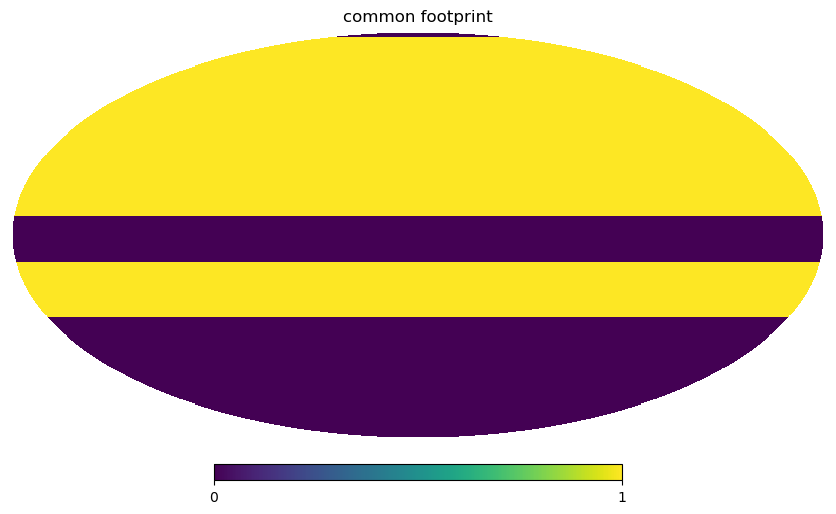

In [23]:
lwa_nans = np.ma.masked_invalid(maps[35] ).mask  
#chipass_nans = np.ma.masked_invalid(maps[1400] ).mask   
#jonas_nans = np.ma.masked_invalid(maps[2326]).mask
quijote_mask=  np.ma.masked_invalid(maps[11000]).mask
#common_footprint = np.logical_and(np.logical_and(~lwa_nans, ~chipass_nans) , ~jonas_nans) #, ~quijote_mask)  
common_footprint =  np.logical_and(~lwa_nans , ~quijote_mask)  
hp.mollview(common_footprint, title='common footprint' ) 


In [24]:
fstring="COM_CompMap_freefree-commander_0256_R2.00.fits"
try :
    print(f"reading {fstring} ")
    tmp=  hp.read_map(filename=f"../lwa_data/{fstring}" ,field= ['EM_ML', 'TEMP_ML']  )  
except FileNotFoundError: 
    filename = wget.download( f"http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_freefree-commander_0256_R2.00.fits" , out ="../lwa_data")
    tmp=  hp.read_map(f"../lwa_data/{fstring}" ,field= ['EM_ML', 'TEMP_ML']  )
 
planck_em = tmp[0]* u.cm**-6 *u.pc
planck_te = tmp [1]*u.K 

fstring = "EM_mean_std.fits"
try :
    print(f"reading {fstring} ")
    hust=  hp.read_map(filename=f"../lwa_data/{fstring}"   )  
except FileNotFoundError: 
    filename = wget.download( f"https://zenodo.org/records/10523170/files/EM_mean_std.fits" , out ="../lwa_data")
    hust =  hp.read_map(f"../lwa_data/{fstring}"    )
hust *= u.cm**-6 *u.pc

reading COM_CompMap_freefree-commander_0256_R2.00.fits 
reading EM_mean_std.fits 


In [25]:

Tff = lambda Te , nu,EM  : Te * (1.0 - np.exp(-tauff(Te,nu, EM ))) 
tauff = lambda Te,nu , EM : 0.05468 *   (Te.value )**-1.5 * (nu.value )**-2 *EM.value   *gff (Te,nu) 
Zi =1 
gff =lambda Te ,nu :  np.log (np.exp(1.0) +np.exp (5.960 -np.sqrt(3)/np.pi *np.log (Zi *nu.to(u.GHz).value *(Te/(1e4*u.K)  )**-1.5  )) )  

free ={} 
for fr in maps.keys() : 
    tmp = Tff(Te=planck_te, nu=(fr*u.MHz).to(u.GHz), EM=planck_em  )
    tmp = hp.smoothing(tmp   , fwhm=pl.sqrt(fwhms[35]**2 -  1*u.deg **2 ).to(u.rad).value  )
    free[fr]= rotate_map(tmp , 'G', 'C')* (maps[35].unit)  



/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_61842/3810562272.py:5: RuntimeWarning: invalid value encountered in log10
  hp.mollview(  pl.log10((m .value  -free[fr ].value  )  )   ,  title=f'{fr} MHz'  , sub=(4,4,1+j) , notext=True ,  coord='CG',   )


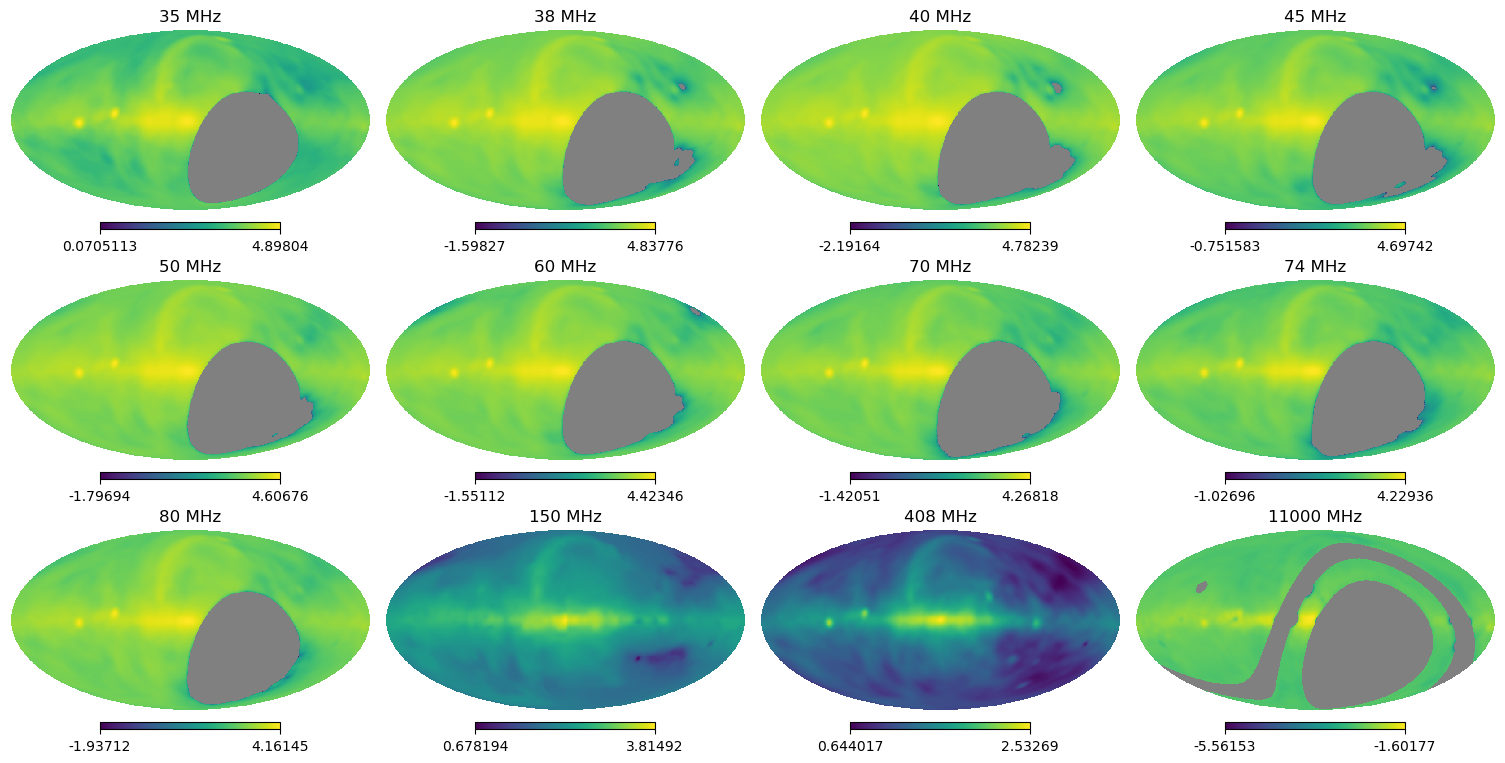

In [64]:
pl.figure(figsize=(15,10)) 
j=0
for fr,m in maps.items():
     
    hp.mollview(  pl.log10((m .value  -free[fr ].value  )  )   ,  title=f'{fr} MHz'  , sub=(4,4,1+j) , notext=True ,  coord='CG',   )
    
    j+=1

pl.show() 

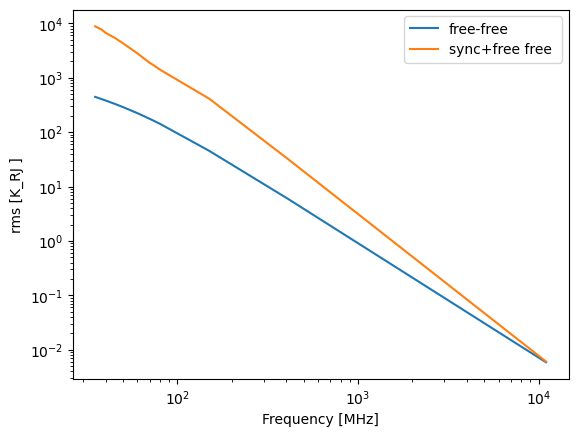

In [65]:
rmsf =np.array( [ np.nanstd(f .value)    for f in free.values() ] ) 
rmsm = np.array( [ np.nanstd(m .value)    for m in maps.values() ] ) 
pl.loglog( freqs, rmsf  ,label='free-free' ,)
pl.loglog( freqs, rmsm  , label='sync+free free ', )

pl.legend()
pl.xlabel('Frequency [MHz]')
pl.ylabel('rms [K_RJ ]')  
pl.show() 


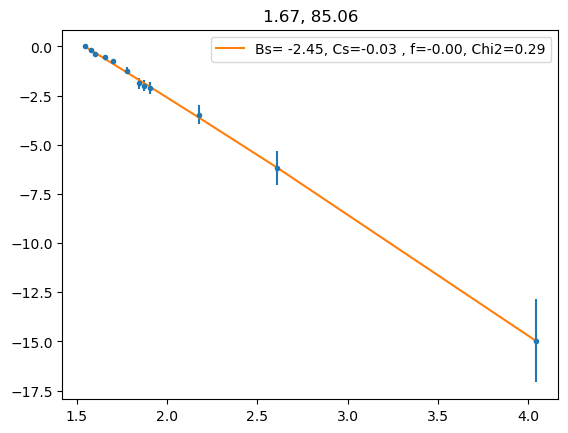

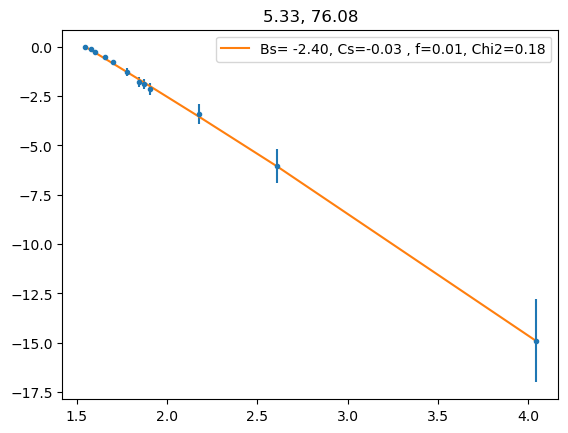

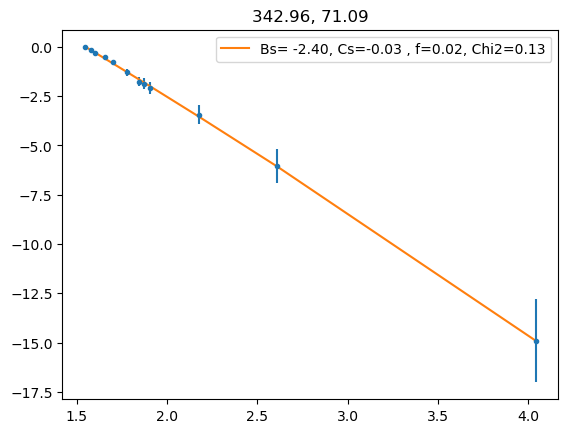

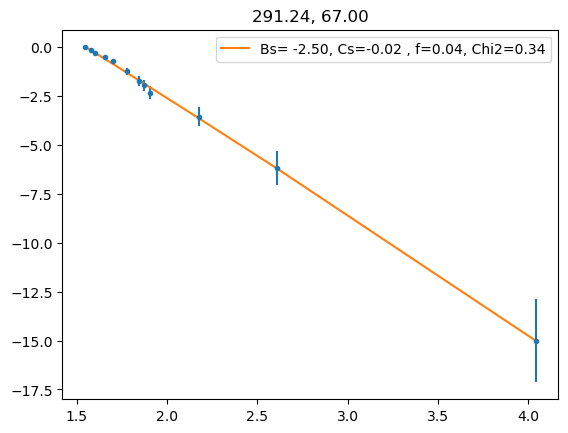

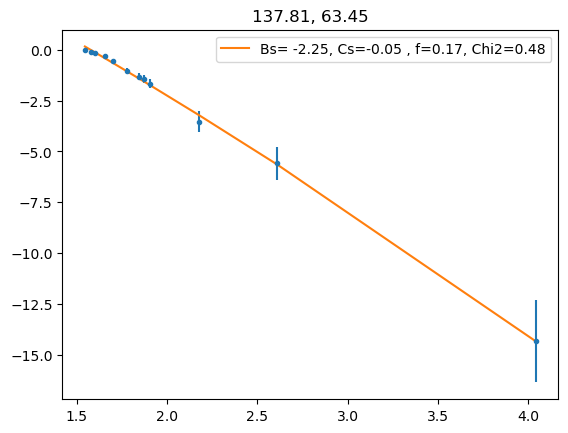

In [50]:

def fitting_beta_curvature(X, beta, cs, const):
   return beta*X +cs*X*X + const
def process_pixel(ipix):
    ifreq= np.argmin(np.abs(freqs - 35     ))
    pixvals = np.array([ (m[ipix].value - free[k][ipix ] .value)  for k, m in maps.items() ])
    nans = np.isnan(pixvals)
    ydat = pl.log(pixvals / pixvals[ifreq])
    xdat = pl.log(freqs / freqs[ifreq] )
    yerr = np.full_like(ydat, np.sqrt(2) * 0.1) * np.fabs(ydat) 
    logyerr = np.full_like(ydat, np.sqrt(2) * 0.15) 
    p0 = np.array([-3, 
                   -0.1,
                  1 ,
                  #-2.13, 
                    ])
    ret = np.full( p0.size +2 , np.nan )
    ret[0] = ipix 
    if nans.sum():
        return ret 
    try:
        popt, pcov = curve_fit(fitting_beta_curvature, xdat, ydat, 
                               sigma=   logyerr,  p0=p0    ) 
                               #bounds=[(-3.8, -0.5, 0), (-2.0, 0.0, 1)])
        ret[-1] = np.sum(((ydat - fitting_beta_curvature(xdat, *popt)) / logyerr) ** 2)/(xdat.size -p0.size   )
        ret [1:-1] = popt 
        return ret 
    except :
        return ret 
    


pixel_select= np.arange ( npix )[common_footprint ]
 
ifreq= np.argmin(np.abs(freqs - 35       ))

xdat =   pl.log(freqs  /freqs[ifreq]) 
betamap = np.full(hp.nside2npix(nside ), np.nan)
fmap=  np.full(hp.nside2npix(nside ), np.nan)
csmap = np.full(hp.nside2npix(nside ), np.nan)
betafmap = np.full(hp.nside2npix(nside), np.nan)
chisquare_map = np.full(hp.nside2npix(nside), np.nan)
jj=0 
for ipix  in pixel_select[::1000]:
    pixvals = np.array([(m[ipix].value - free[k][ipix ] .value  ) for k, m in maps.items()])
   

    ydat = pl.log( pixvals / pixvals[ifreq])

    yerr = np.full_like(ydat, np.sqrt(2) * .1)* np.fabs(ydat) 
 
    logyerr = np.full_like(ydat, np.sqrt(2) * 0.1) 
    fitted_params =process_pixel(ipix)
    #  beta, cs,facta, betaf

    betamap[ipix] = fitted_params[1]
    fmap[ipix] =   fitted_params[3]
    #betafmap[ipix] = fitted_params[4]

    csmap[ipix] = fitted_params[2]
    chisquare_map[ipix] = fitted_params[-1]

    if jj%10==0:
        pl.figure() 
        lon,lat =hp.pix2ang(ipix=ipix, nside=hp.get_nside(maps[35]), lonlat=True) 
        pl.title( f"{lon:.2f}, {lat:.2f}" )
        pl.errorbar ( pl.log10(freqs) ,  ydat ,
                     yerr= yerr  ,
                        fmt='.' )
         
        pl.plot( pl.log10(freqs) ,  fitting_beta_curvature( xdat , *fitted_params[1:-1] ),  
                label =f'Bs= {fitted_params[1]:.2f}, Cs={fitted_params[2]:.2f} , f={fitted_params[3]:.2f}, Chi2={fitted_params[-1]:.2f}' ) 
                #, Bf={fitted_params[4]:.2f}, 

        #pl.semilogx() 
        #pl.loglog() 
        pl.legend() 
    jj+=1 
    if jj== 50: break
    #break 
pl.show() 

In [54]:
from concurrent.futures import ThreadPoolExecutor
import tqdm

    
# Initialize shared arrays
betamap = np.full(hp.nside2npix(nside), np.nan)
fmap = np.full(hp.nside2npix(nside), np.nan)
csmap = np.full(hp.nside2npix(nside), np.nan)
betafmap = np.full(hp.nside2npix(nside), np.nan)
chisquare_map = np.full(hp.nside2npix(nside), np.nan)


# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    results = list(tqdm.tqdm(executor.map(process_pixel, pixel_select), total=len(pixel_select)))

for fitted_params in results:
    ipix = int(fitted_params[0])  # Ensure ipix is an integer
    betamap[ipix] = fitted_params[1]
    csmap[ipix] = fitted_params[2]
    fmap[ipix] =   fitted_params[3]
    #betafmap[ipix] = fitted_params[4]

    chisquare_map[ipix] = fitted_params[-1]

 29%|██▉       | 138027/473220 [00:15<01:38, 3399.00it/s]/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_61842/414559909.py:7: RuntimeWarning: invalid value encountered in log
  ydat = pl.log(pixvals / pixvals[ifreq])
100%|██████████| 473220/473220 [00:59<00:00, 7921.15it/s] 


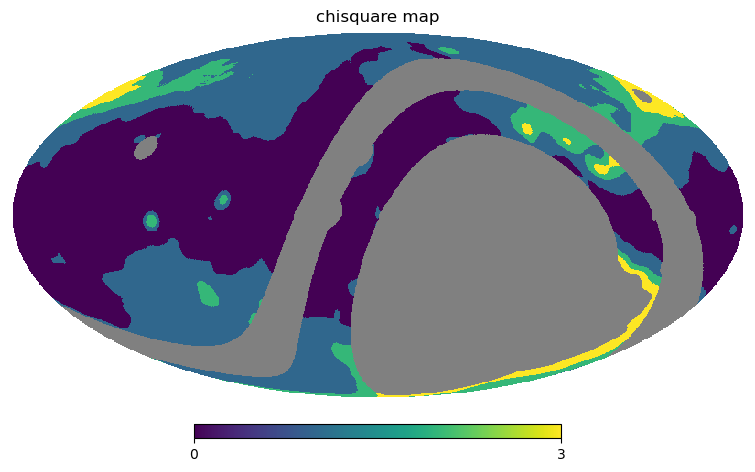

In [92]:
clust = np.ones_like (chisquare_map) 

mask  = np.ma.masked_inside (chisquare_map , 0.5,2).mask
clust[mask] = 1
clust[~mask] = 0
mask =np.ma.masked_inside (chisquare_map , 2,5).mask
clust[mask] = 2 
mask =np.ma.masked_greater(chisquare_map , 5).mask
clust[mask] = 3
clust[np.ma.masked_invalid(chisquare_map).mask] = np.nan 
pl.figure(figsize=(15,10))
hp.mollview(clust, title='chisquare map', sub=(2,2,1),   notext=True, min=0, max=3, coord='CG')
pl.show() 


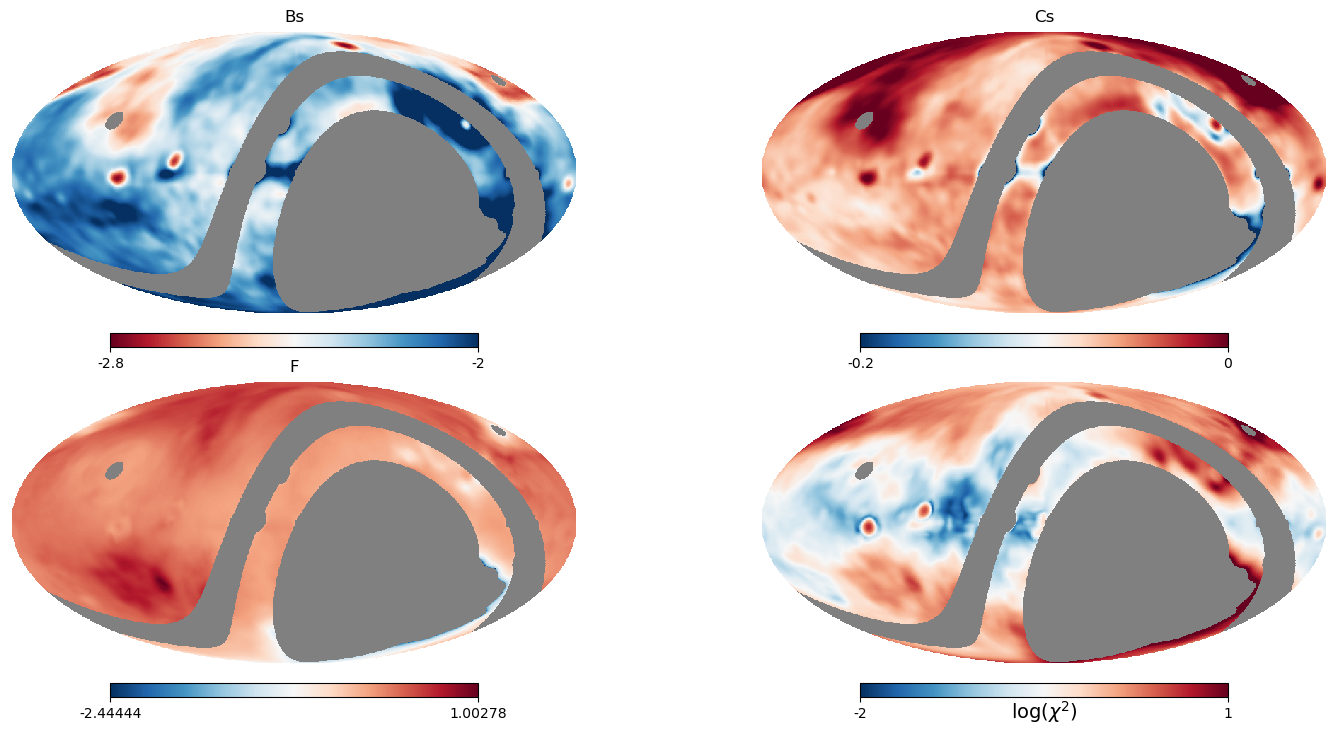

In [83]:
pl.figure(figsize=(15,7 ))
hp.mollview(betamap , sub=221 , min=-2.8,max=- 2., title ='Bs',cmap='RdBu',coord='CG', notext=True) 
#hp.mollview(betafmap , sub=233, min=-3,max=-1,  title ='Bf',cmap='RdBu',coord='CG') 
hp.mollview(csmap , sub=222, min=-0.2,max=0. ,title='Cs',cmap='RdBu_r',coord='CG', notext=True) 
hp.mollview(fmap  , sub=223,   title='F',cmap='RdBu_r',coord='CG', notext=True) 
hp.mollview(np.log10(chisquare_map)   , sub=224,  min=-2 ,max=1,    unit=r'$\log (\chi^2)$',cmap='RdBu_r',coord='CG',notext=True , title=' ' ) 
pl.show()


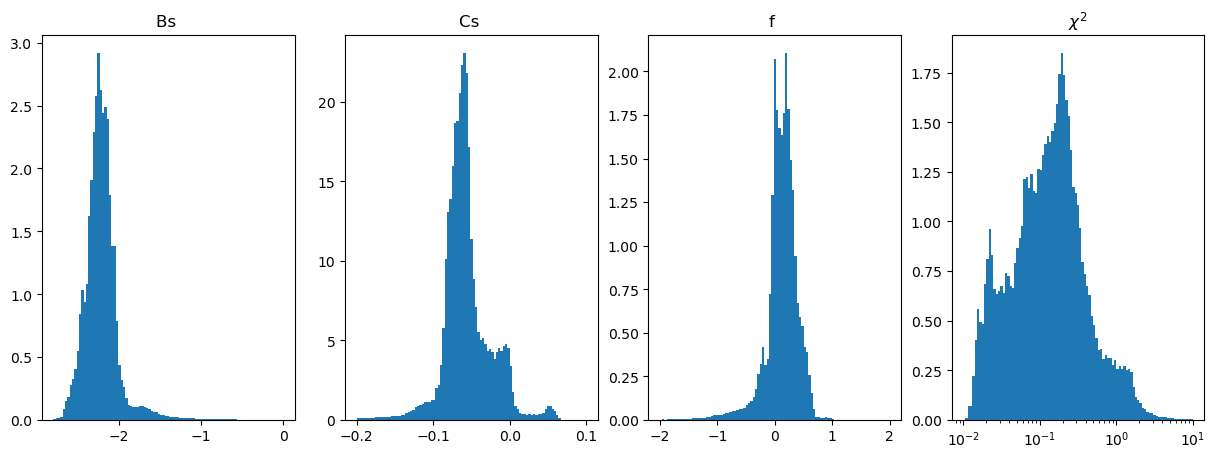

In [71]:
pl.figure(figsize=(15,5))
pl.subplot(141) 
pl.title ('Bs ')
cb= pl.hist(betamap, bins=np.linspace(-2.8, -0, 100), density=True ) 
pl.subplot(142) 
pl.title ('Cs ')
cc= pl.hist(csmap, bins=np.linspace(-.2,  .1, 100), density=True  )
#pl.subplot(153) 
#pl.title ('Bf ')
#pl.hist(betafmap, bins=np.linspace(-3 , 2.0, 100), density=True  )

pl.subplot(143) 
pl.title ('f ') 
pl.hist(fmap, bins=np.linspace(-2, 2.0, 100), density=True  )
pl.subplot(144)
pl.title (r'$\chi^2$') 
_=pl.hist(chisquare_map, bins=np.logspace(-2, 1.0, 100), density=True  )
pl.semilogx ()
pl.show() 


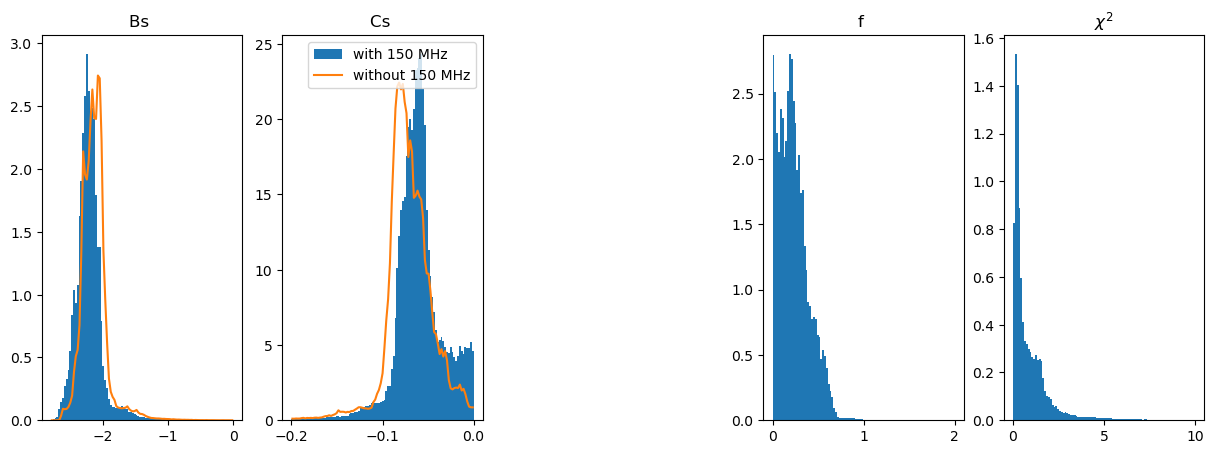

In [56]:
pl.figure(figsize=(15,5))
pl.subplot(151) 
pl.title ('Bs ')
pl.hist(betamap, bins=np.linspace(-2.8, -0, 100), density=True ) 
bins = [(cb[1][i] + cb[1][i+1] ) / 2 for i in range(len(cb[1])-1)]
pl.plot (bins, cb[0] )
pl.subplot(152) 
pl.title ('Cs ')
pl.hist(csmap, bins=np.linspace(-.2,  .0, 100), density=True, label='with 150 MHz')
bins = [(cc[1][i] + cc[1][i+1] ) / 2 for i in range(len(cc[1])-1)]
pl.plot (bins, cc[0] , label = 'without 150 MHz')
#pl.subplot(153) 
#pl.title ('Bf ')
#pl.hist(betafmap, bins=np.linspace(-3 , 2.0, 100), density=True  )
pl.legend() 
pl.subplot(154) 
pl.title ('f ') 
pl.hist(fmap, bins=np.linspace(0, 2.0, 100), density=True  )
pl.subplot(155)
pl.title (r'$\chi^2$') 
_=pl.hist(chisquare_map, bins=np.linspace(0, 10.0, 100), density=True  )
pl.show() 


## Fitting linear 

[   35    38    40    45    50    60    70    74    80   150   408 11000]


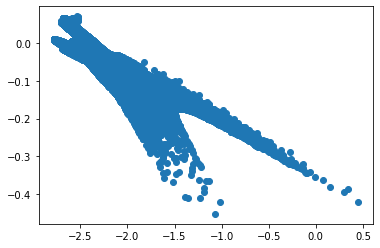

In [50]:

def fitting_sync_ff(X,  beta, cs,facta): 
                    #, betaf ):
   return ( facta * X**(beta + cs * np.log(X) )  ) 
            #+ (1 - facta) * X**(betaf)) 
def fitting_beta_curvature(X, beta, cs, const):
   return beta*X +cs*X*X + const
def process_pixel(ipix):
    ifreq= np.argmin(np.abs(freqs - 35     ))
    pixvals = np.array([ (m[ipix].value - free[k][ipix ] .value)  for k, m in maps.items() ])
    nans = np.isnan(pixvals)
    ydat = (pixvals / pixvals[ifreq])
    xdat = (freqs / freqs[ifreq] )
    yerr = np.full_like(ydat, np.sqrt(2) * 0.1) * np.fabs(ydat) 
    #logyerr = np.full_like(ydat, np.sqrt(2) * 0.15) 
    p0 = np.array([-3, 
                   -0.1,
                  1 ,
                  #-2.13, 
                    ])
    ret = np.full( p0.size +2 , np.nan )
    ret[0] = ipix 
    if nans.sum():
        return ret 
    try:
        popt, pcov = curve_fit(fitting_sync_ff, xdat, ydat, 
                               sigma=yerr,  p0=p0    ) 
                               #bounds=[(-3.8, -0.5, 0), (-2.0, 0.0, 1)])
        ret[-1] = np.sum(((ydat - fitting_sync_ff(xdat, *popt)) / yerr) ** 2)/(xdat.size -p0.size   )
        ret [1:-1] = popt 
        return ret 
    except :
        return ret 
    


pixel_select= np.arange ( npix )[common_footprint ]
 
ifreq= np.argmin(np.abs(freqs - 35       ))

xdat =   (freqs  /freqs[ifreq]) 
betamap = np.full(hp.nside2npix(nside ), np.nan)
fmap=  np.full(hp.nside2npix(nside ), np.nan)
csmap = np.full(hp.nside2npix(nside ), np.nan)
betafmap = np.full(hp.nside2npix(nside), np.nan)
chisquare_map = np.full(hp.nside2npix(nside), np.nan)
jj=0 
for ipix  in pixel_select[::1000]:
    pixvals = np.array([(m[ipix].value - free[k][ipix ] .value  ) for k, m in maps.items()])
   

    ydat = ( pixvals / pixvals[ifreq])

    yerr = np.full_like(ydat, np.sqrt(2) * .1)* np.fabs(ydat) 
 
    #logyerr = np.full_like(ydat, np.sqrt(2) * 0.15) 
    fitted_params =process_pixel(ipix)
    #  beta, cs,facta, betaf

    betamap[ipix] = fitted_params[1]
    fmap[ipix] =   fitted_params[3]
    #betafmap[ipix] = fitted_params[4]

    csmap[ipix] = fitted_params[2]
    chisquare_map[ipix] = fitted_params[-1]

    if jj%10==0:
        pl.figure() 
        lon,lat =hp.pix2ang(ipix=ipix, nside=hp.get_nside(maps[35]), lonlat=True) 
        pl.title( f"{lon:.2f}, {lat:.2f}" )
        pl.errorbar ( freqs ,  ydat ,
                     yerr= yerr  ,
                        fmt='.' )
         
        pl.plot( freqs ,  fitting_sync_ff( xdat , *fitted_params[1:-1] ),  
                label =f'Bs= {fitted_params[1]:.2f}, Cs={fitted_params[2]:.2f} , f={fitted_params[3]:.2f}, Chi2={fitted_params[-1]:.2f}' ) 
                #, Bf={fitted_params[4]:.2f}, 

        #pl.semilogx() 
        pl.loglog() 
        pl.legend() 
    jj+=1 
    if jj== 50: break
    #break 
pl.show() 